In [1]:
## Has a lot of already implemented adversarial attacks like FGSM, PGD, BIM, CW, DeepFool etc.

!pip install torchattacks

     |████████████████████████████████| 105 kB 35.1 MB/s 


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
import cv2
import pickle
import torchattacks
import random
from torchvision import models
import copy
from PIL import Image
import io
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!nvidia-smi

Tue May 10 03:02:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
## Code loosely from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

class FGSM():

    def __init__(self, loss_fn, fgsm_epsilon):

        self.fgsm_epsilon = fgsm_epsilon
        self.loss_fn = loss_fn

    def get_sample(self, model, x, y):
    
        x.requires_grad = True
        logits = model(x)
        prediction = F.softmax(logits, dim=1)
        loss = self.loss_fn(prediction, y)
        loss.backward()
        
        x_grad = x.grad.data
        sign = x_grad.sign()
        x_adv = x + self.fgsm_epsilon*sign
        x_adv = torch.clamp(x_adv, 0, 1)

        return x_adv

In [6]:
## Code from https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

class PGD():

    def __init__(self, loss_fn, num_steps, step_size, eps, step_norm, eps_norm, clamp=(0,1)):

        self.loss_fn = loss_fn
        self.num_steps = num_steps
        self.step_size = step_size
        self.eps = eps
        self.step_norm = step_norm
        self.eps_norm = eps_norm
        self.clamp = clamp

    def get_sample(self, model, x, y, y_target=None):

        x_adv = x.clone().to(device)
        targeted = y_target is not None
        num_channels = x.shape[1]

        for i in range(self.num_steps):
            # _x_adv = x_adv.clone().detach().requires_grad_(True)
            _x_adv = x_adv.clone()
            _x_adv.requires_grad = True

            logits = model(_x_adv)
            prediction = F.softmax(logits, dim=1)
            loss = self.loss_fn(prediction, y_target if targeted else y)
            loss.backward()

                # Force the gradient step to be a fixed size in a certain norm
            if self.step_norm == 'inf':
                gradients = _x_adv.grad.sign() * self.step_size
            else:
                    # Note .view() assumes batched image data as 4D tensor
                gradients = _x_adv.grad * self.step_size / _x_adv.grad.view(_x_adv.shape[0], num_channels, -1)\
                    .norm(self.step_norm, dim=-1)\
                    .view(-1, num_channels, 1, 1)

            if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                x_adv -= gradients
            else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                x_adv += gradients

            # Project back into l_norm ball and correct range
            if self.eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv = torch.max(torch.min(x_adv, x + self.eps), x - self.eps)
            else:
                delta = x_adv - x

                # Assume x and x_adv are batched tensors where the first dimension is
                # a batch dimension
                mask = delta.view(delta.shape[0], -1).norm(self.eps_norm, dim=1) <= self.eps

                scaling_factor = delta.view(delta.shape[0], -1).norm(self.eps_norm, dim=1)
                scaling_factor[mask] = self.eps

                # .view() assumes batched images as a 4D Tensor
                delta *= self.eps / scaling_factor.view(-1, 1, 1, 1)

                x_adv = x + delta
                
            x_adv = x_adv.clamp(*self.clamp)

        # return x_adv.detach().cpu()
        return x_adv

In [7]:
class LeNet5_Classifier(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5_Classifier, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=3),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        # return logits, probs
        return logits

In [8]:
# Code form https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])
def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)
def ResNet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)
def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])
def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [9]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [10]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0005
IMG_SIZE = 32
N_CLASSES = 10

torch.manual_seed(RANDOM_SEED)

# adv_model = ResNet34(num_classes = 10).to(device)

# adv_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True).to(device)

# state_dict = torch.load('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/resnet_cifar10.pth')
# adv_model.load_state_dict(state_dict)

# adv_model = models.vgg16(pretrained = True)
# input_lastLayer = adv_model.classifier[6].in_features
# adv_model.classifier[6] = nn.Linear(input_lastLayer, N_CLASSES)
# adv_model = adv_model.to(device)

# if device == 'cpu':
#     # adv_model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/ResNet_34_wt_CIFAR10_normal_trained_model.pkl', 'rb')).load()
#     adv_model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_CIFAR10_normal_trained_model.pkl', 'rb')).load()
# else:
#     # adv_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/ResNet_34_wt_CIFAR10_normal_trained_model.pkl', 'rb'))
#     adv_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_CIFAR10_normal_trained_model.pkl', 'rb'))
#     # adv_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/CIFAR10_binary_224_all_attacks_varied_params_trained_model.pkl', 'rb')).to(device)

# # model = ResNet50(num_classes = 3).to(device)
model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer, 3)
model = model.to(device)

if device == 'cpu':
    model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/CIFAR10_224_all_attacks_varied_params_trained_model.pkl', 'rb')).load()
else:
    model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/t4.pkl', 'rb')).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.9,weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

logs = {}
logs['epochs'] = 0
logs['Train loss'] = []
logs['Valid loss'] = []
logs['Train acc'] = []
logs['Valid acc'] = []
logs['ADV Valid acc'] = []
logs['ADV Valid loss'] = []

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [11]:
# adv_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True).to(device)

# adv_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)

# adv_model = models.vgg16(pretrained = True)
# input_lastLayer = adv_model.classifier[6].in_features
# adv_model.classifier[6] = nn.Linear(input_lastLayer, N_CLASSES)
# adv_model = adv_model.to(device)

if device == 'cpu':
    adv_model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/ResNet_34_wt_224_CIFAR10_normal_trained_model.pkl', 'rb')).load()
    # adv_model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/DenseNet_121_wt_224_CIFAR100_normal_trained_model.pkl', 'rb')).load()
    # adv_model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_224_CIFAR100_normal_trained_model.pkl', 'rb')).load()
else:
    adv_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/ResNet_34_wt_224_CIFAR10_normal_trained_model.pkl', 'rb'))
    # adv_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/DenseNet_121_wt_224_CIFAR100_normal_trained_model.pkl', 'rb'))
    # adv_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_224_CIFAR100_normal_trained_model.pkl', 'rb'))
    # adv_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/CIFAR10_binary_224_all_attacks_varied_params_trained_model.pkl', 'rb')).to(device)


In [12]:
pgd_linf = PGD(loss_fn=torch.nn.CrossEntropyLoss(), num_steps = 5, step_size = 0.006, eps = 0.03, step_norm = 'inf', eps_norm = 'inf')
pgd_l2 = PGD(loss_fn=torch.nn.CrossEntropyLoss(), num_steps = 5, step_size = 0.02, eps = 0.1, step_norm = 2, eps_norm = 2)
fgsm = FGSM(loss_fn=torch.nn.CrossEntropyLoss(), fgsm_epsilon = 0.05)
cw = torchattacks.CW(adv_model, c=1, kappa=0, steps=5, lr=0.01)
deepfool = torchattacks.DeepFool(adv_model, steps=50, overshoot=0.2)

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

trainData = unpickle('/content/drive/MyDrive/Adversarial Machine Learning/Datasets/CIFAR-100/cifar-100-python/train')
#type of items in each file
for item in trainData:
    print(item, type(trainData[item]))

testData = unpickle('/content/drive/MyDrive/Adversarial Machine Learning/Datasets/CIFAR-100/cifar-100-python/test')
#type of items in each file

X_train = trainData['data']
X_test = testData['data']
y_train = trainData['fine_labels']
y_test = testData['fine_labels']

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [13]:
import platform
import os

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

# Load the raw CIFAR-10 data
cifar10_dir = '/content/drive/MyDrive/Adversarial Machine Learning/Datasets/CIFAR-10/cifar-10-batches-py/'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print(len(X_train[0]))

3072


In [14]:
class CIFAR10AdversarialDataset(Dataset):

    def __init__(self, data, labels, attack, adv_model, transform=None):
        
        self.data = data[:int(0.2*len(data))]
        # self.data = data
        self.labels = labels
        self.transform = transform
        self.adv_threshold = 0.5
        self.noise_threshold = 0.5
        self.adv_model = adv_model
        self.attack = attack

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        y_true = self.labels[idx]
        y_true = torch.tensor(y_true, device=device)
        rand = random.random()
        
        img = self.data[idx]
        x = np.reshape(img, (3, 32, 32))
        x = x.transpose(1, 2, 0)
        x = Image.fromarray(x)

        if self.transform:
            x = self.transform(x)
        
        x = x.to(device)
        if rand < self.adv_threshold:
            if self.attack == 'pgd-l2':
                # y_true = 2
                # y_true = torch.tensor(y_true, device=device)
                x = pgd_l2.get_sample(adv_model, x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                y_true = 2
            elif self.attack == 'pgd-linf':
                # y_true = 1
                # y_true = torch.tensor(y_true, device=device)
                x = pgd_linf.get_sample(adv_model, x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                y_true = 1
            elif self.attack == 'fgsm':
                # y_true = 1
                # y_true = torch.tensor(y_true, device=device)
                x = fgsm.get_sample(adv_model, x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                y_true = 1
            elif self.attack == 'deepfool':
                x_adv = deepfool(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                n_changed = torch.sum(x != x_adv).item() / x.size(0)
                if n_changed == 0:
                    y_true = 0
                else:
                    x = x_adv
                    y_true = 2
            elif self.attack == 'cw':
                x_adv = cw(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                n_changed = torch.sum(x != x_adv).item()
                if n_changed == 0:
                    y_true = 0
                else:
                    x = x_adv
                    y_true = 2
        else:
            rand = random.random()
            if rand < self.noise_threshold:
                if self.attack == 'pgd-linf':
                    x = x + torch.randn(x.size()).to(device) * pgd_linf.eps + 0
                elif self.attack == 'pgd-l2':
                    x = x + torch.randn(x.size()).to(device) * 0.1 + 0
                elif self.attack == 'fgsm':
                    x = x + torch.randn(x.size()).to(device) * fgsm.fgsm_epsilon + 0
                elif self.attack == 'cw' or self.attack == 'deepfool':
                    x = x + torch.randn(x.size()).to(device) * 0.1 + 0
                    # x_adv = cw(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                    # if torch.sum(x != x_adv).item() != 0:
                    #     x_adv_flat = x_adv.view(-1)
                    #     n_changed = torch.sum(x != x_adv).item() / x_adv_flat.size(0)
                    #     idx = torch.randperm(x_adv_flat.size(0))[:int(x_adv_flat.size(0)*n_changed)]
                    #     x = x.view(-1)
                    #     x[idx] = random.random()
                    #     x = x.view(x_adv.size())
            y_true = 0
        
        return x.to(device).detach(), y_true

In [15]:
BATCH_SIZE = 32

transformations = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

train_dataset = CIFAR10AdversarialDataset(X_train, y_train, None, adv_model, transformations)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

valid_dataset = CIFAR10AdversarialDataset(X_test, y_test, None, adv_model, transformations)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

In [16]:
train_dataset.attack = 'fgsm'
valid_dataset.attack = 'fgsm'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


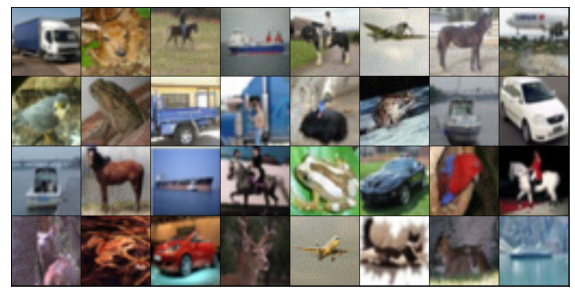

In [17]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import rgb_to_grayscale

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach().cpu()[:nmax])).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for samples in dl:
        show_images(samples[0], nmax)
        break

show_batch(train_loader)

In [18]:
def train(train_dataset, train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    correct_pred = 0 
    n = 0
    
    model.train()
    running_loss = 0
    attack_list = ['pgd-linf', 'pgd-l2', 'cw']
    
    for X, y_true in tqdm(train_loader):

        rand = random.randint(0,len(attack_list)-1)

        # fgsm_eps = np.random.uniform(0.005, 0.1)
        fgsm_eps = 0.05
        fgsm.fgsm_epsilon = fgsm_eps

        # pgd_linf_eps = np.random.uniform(0.005, 0.1)
        pgd_linf.eps = 0.05
        pgd_linf.step_size = pgd_linf.eps / pgd_linf.num_steps

        # pgd_l2_eps = np.random.uniform(0.1, 3)
        pgd_l2.eps = 1
        pgd_l2.step_size = pgd_l2.eps / pgd_l2.num_steps

        # cw.lr = np.random.uniform(0.0075, 0.1)
        cw.lr = 0.01

        train_dataset.attack = attack_list[rand]
        # print(train_dataset.attack)
        
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        # y_hat = model(rgb_to_grayscale(X, num_output_channels = 1))
        y_hat = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    acc = correct_pred.float() / n
    return model, optimizer, epoch_loss, acc

In [24]:
def validate(valid_dataset, valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    correct_pred = 0 
    n = 0
    
    model.eval()
    running_loss = 0

    y_pos_prob_total = []
    y_true_total = []

    attack_list = ['pgd-l2']
    
    for X, y_true in tqdm(valid_loader):
    
        X = X.to(device)
        y_true = y_true.to(device)

        rand = random.randint(0,len(attack_list)-1)

        # fgsm_eps = np.random.uniform(0.005, 0.1)
        # fgsm_eps = 0.05
        # fgsm.fgsm_epsilon = fgsm_eps

        # pgd_linf_eps = np.random.uniform(0.005, 0.1)
        # pgd_linf.eps = 0.05
        # pgd_linf.step_size = pgd_linf.eps / pgd_linf.num_steps

        # # pgd_l2_eps = np.random.uniform(0.1, 3)
        # pgd_l2.eps = 1
        # pgd_l2.step_size = pgd_l2.eps / pgd_l2.num_steps

        # # cw.lr = np.random.uniform(0.0075, 0.1)
        # cw.lr = 0.01

        # valid_dataset.attack = attack_list[rand]
        
        # Forward pass and record loss
        # y_hat = model(rgb_to_grayscale(X, num_output_channels = 1))
        y_hat = model(X)
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        t = torch.max(y_prob[:, 1:], dim=1)[0].detach()
        y_pos_prob_total = y_pos_prob_total + t.tolist()
        y_true_total = y_true_total + torch.minimum(y_true, torch.ones(y_true.shape, device=device)).tolist()

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()

    epoch_loss = running_loss / len(valid_loader.dataset)
    acc = correct_pred.float() / n

    auc_score = roc_auc_score(y_true_total, y_pos_prob_total)
        
    return model, epoch_loss, acc, auc_score

In [20]:
def training_loop(model, criterion, optimizer, train_dataset, train_loader, valid_dataset, valid_loader, epochs, device, logs, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    start_epoch = logs['epochs']
 
    # Train model
    for epoch in range(start_epoch, epochs):

        # training
        model, optimizer, train_loss, train_acc = train(train_dataset, train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        model, valid_loss, valid_acc, auc_score = validate(valid_dataset, valid_loader, model, criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                        
            logs['epochs'] = epoch + 1
            logs['Train loss'].append(train_loss)
            logs['Valid loss'].append(valid_loss)
            logs['Train acc'].append(train_acc)
            logs['Valid acc'].append(valid_acc)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train acc: {100 * train_acc:.2f}\t'
                  f'Valid acc: {100 * valid_acc:.2f}')
            
            # save_model(model, optimizer, epoch, logs)

    # plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [21]:
def only_val_loop(model, criterion, valid_dataset, valid_loader, epochs, device, print_every=1):
    
    valid_losses = []

    for epoch in range(0, epochs):

        # validation
        model, valid_loss, valid_acc, auc_score = validate(valid_dataset, valid_loader, model, criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                        
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Valid acc: {100 * valid_acc:.2f}\t')

    # plot_losses(train_losses, valid_losses)
    
    return model, valid_acc, auc_score

In [ ]:
## t1 -> ['pgd-linf', 'pgd-l2', 'cw'] ==> 90%
## t2 -> ['fgsm', 'pgd-l2', 'cw'] ==> 87%
## t3 -> ['pgd-linf', 'cw'] ==> 76%
## t4 -> static ['pgd-linf', 'pgd-l2', 'cw'] ==> 80%

N_EPOCHS = 5

model, optimizer, _ = training_loop(model, criterion, optimizer, train_dataset, train_loader, valid_dataset, valid_loader, N_EPOCHS, device, logs)

100%|██████████| 63/63 [03:02<00:00,  2.90s/it]


03:01:02 --- Epoch: 0	Train loss: 0.1207	Valid loss: 2.1471	Train acc: 96.49	Valid acc: 80.80


 15%|█▌        | 48/313 [03:51<21:18,  4.83s/it]


KeyboardInterrupt: ignored

In [22]:
valid_dataset.attack = 'fgsm'

model, _, auc_score = only_val_loop(model, criterion, valid_dataset, valid_loader, 1, device)

print('AUC score:', auc_score)

100%|██████████| 63/63 [00:29<00:00,  2.13it/s]

03:05:23 --- Epoch: 0	Valid loss: 5.5544	Valid acc: 48.50	
AUC score: 0.21396656991292162


In [26]:
model1 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/t1.pkl', 'rb'))
# model2 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/t2.pkl', 'rb'))
model3 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/t3.pkl', 'rb'))
model4 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/t4.pkl', 'rb'))

model_list = [model1, model3, model4]

fgsm_epsilon_list = list(np.linspace(0.05, 5, num=15, endpoint=True))
acc_dict = {}
valid_dataset.attack = 'pgd-l2'

for fgsm_epsilon in fgsm_epsilon_list:

    model_acc_list = []
    # cw.lr = fgsm_epsilon
    pgd_l2.eps = fgsm_epsilon
    pgd_l2.step_size = pgd_l2.eps / pgd_l2.num_steps

    for model in model_list:

        print('FGSM attack with epsilon', fgsm_epsilon, 'result:')
        model, _, auc_score = only_val_loop(model, criterion, valid_dataset, valid_loader, 1, device)
        model_acc_list.append(auc_score)

    acc_dict[fgsm_epsilon] = tuple(model_acc_list)

FGSM attack with epsilon 0.05 result:


100%|██████████| 63/63 [01:31<00:00,  1.45s/it]


03:11:08 --- Epoch: 0	Valid loss: 1.6295	Valid acc: 50.40	
FGSM attack with epsilon 0.05 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


03:12:41 --- Epoch: 0	Valid loss: 1.8461	Valid acc: 50.35	
FGSM attack with epsilon 0.05 result:


100%|██████████| 63/63 [01:32<00:00,  1.47s/it]


03:14:14 --- Epoch: 0	Valid loss: 2.1597	Valid acc: 51.10	
FGSM attack with epsilon 0.4035714285714286 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


03:15:47 --- Epoch: 0	Valid loss: 0.6672	Valid acc: 64.40	
FGSM attack with epsilon 0.4035714285714286 result:


100%|██████████| 63/63 [01:38<00:00,  1.57s/it]


03:17:26 --- Epoch: 0	Valid loss: 1.8301	Valid acc: 48.70	
FGSM attack with epsilon 0.4035714285714286 result:


100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


03:19:01 --- Epoch: 0	Valid loss: 1.3042	Valid acc: 60.00	
FGSM attack with epsilon 0.7571428571428572 result:


100%|██████████| 63/63 [01:37<00:00,  1.55s/it]


03:20:38 --- Epoch: 0	Valid loss: 0.0465	Valid acc: 99.95	
FGSM attack with epsilon 0.7571428571428572 result:


100%|██████████| 63/63 [01:32<00:00,  1.47s/it]


03:22:11 --- Epoch: 0	Valid loss: 1.3119	Valid acc: 51.60	
FGSM attack with epsilon 0.7571428571428572 result:


100%|██████████| 63/63 [01:37<00:00,  1.55s/it]


03:23:49 --- Epoch: 0	Valid loss: 0.0072	Valid acc: 99.90	
FGSM attack with epsilon 1.1107142857142858 result:


100%|██████████| 63/63 [01:35<00:00,  1.51s/it]


03:25:24 --- Epoch: 0	Valid loss: 0.0366	Valid acc: 99.60	
FGSM attack with epsilon 1.1107142857142858 result:


100%|██████████| 63/63 [01:37<00:00,  1.55s/it]


03:27:02 --- Epoch: 0	Valid loss: 0.7928	Valid acc: 47.75	
FGSM attack with epsilon 1.1107142857142858 result:


100%|██████████| 63/63 [01:35<00:00,  1.52s/it]


03:28:37 --- Epoch: 0	Valid loss: 0.0032	Valid acc: 100.00	
FGSM attack with epsilon 1.4642857142857144 result:


100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


03:30:14 --- Epoch: 0	Valid loss: 0.0544	Valid acc: 98.60	
FGSM attack with epsilon 1.4642857142857144 result:


100%|██████████| 63/63 [01:30<00:00,  1.44s/it]


03:31:44 --- Epoch: 0	Valid loss: 0.5698	Valid acc: 52.10	
FGSM attack with epsilon 1.4642857142857144 result:


100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


03:33:18 --- Epoch: 0	Valid loss: 0.0031	Valid acc: 100.00	
FGSM attack with epsilon 1.817857142857143 result:


100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


03:34:53 --- Epoch: 0	Valid loss: 0.0908	Valid acc: 95.90	
FGSM attack with epsilon 1.817857142857143 result:


100%|██████████| 63/63 [01:34<00:00,  1.51s/it]


03:36:27 --- Epoch: 0	Valid loss: 0.5709	Valid acc: 49.55	
FGSM attack with epsilon 1.817857142857143 result:


100%|██████████| 63/63 [01:31<00:00,  1.46s/it]


03:37:59 --- Epoch: 0	Valid loss: 0.0036	Valid acc: 99.95	
FGSM attack with epsilon 2.1714285714285713 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


03:39:33 --- Epoch: 0	Valid loss: 0.1384	Valid acc: 92.75	
FGSM attack with epsilon 2.1714285714285713 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


03:41:06 --- Epoch: 0	Valid loss: 0.5574	Valid acc: 50.15	
FGSM attack with epsilon 2.1714285714285713 result:


100%|██████████| 63/63 [01:36<00:00,  1.54s/it]


03:42:43 --- Epoch: 0	Valid loss: 0.0032	Valid acc: 100.00	
FGSM attack with epsilon 2.525 result:


100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


03:44:17 --- Epoch: 0	Valid loss: 0.2070	Valid acc: 86.30	
FGSM attack with epsilon 2.525 result:


100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


03:45:53 --- Epoch: 0	Valid loss: 0.5746	Valid acc: 48.05	
FGSM attack with epsilon 2.525 result:


100%|██████████| 63/63 [01:36<00:00,  1.52s/it]


03:47:29 --- Epoch: 0	Valid loss: 0.0031	Valid acc: 100.00	
FGSM attack with epsilon 2.8785714285714286 result:


100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


03:49:03 --- Epoch: 0	Valid loss: 0.2683	Valid acc: 80.85	
FGSM attack with epsilon 2.8785714285714286 result:


100%|██████████| 63/63 [01:32<00:00,  1.47s/it]


03:50:36 --- Epoch: 0	Valid loss: 0.5440	Valid acc: 50.85	
FGSM attack with epsilon 2.8785714285714286 result:


100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


03:52:10 --- Epoch: 0	Valid loss: 0.0032	Valid acc: 100.00	
FGSM attack with epsilon 3.232142857142857 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


03:53:43 --- Epoch: 0	Valid loss: 0.3384	Valid acc: 75.10	
FGSM attack with epsilon 3.232142857142857 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


03:55:17 --- Epoch: 0	Valid loss: 0.5493	Valid acc: 50.20	
FGSM attack with epsilon 3.232142857142857 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


03:56:50 --- Epoch: 0	Valid loss: 0.0036	Valid acc: 99.95	
FGSM attack with epsilon 3.585714285714286 result:


100%|██████████| 63/63 [01:35<00:00,  1.51s/it]


03:58:25 --- Epoch: 0	Valid loss: 0.4047	Valid acc: 69.60	
FGSM attack with epsilon 3.585714285714286 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


03:59:59 --- Epoch: 0	Valid loss: 0.5451	Valid acc: 50.60	
FGSM attack with epsilon 3.585714285714286 result:


100%|██████████| 63/63 [01:35<00:00,  1.52s/it]


04:01:34 --- Epoch: 0	Valid loss: 0.0035	Valid acc: 99.95	
FGSM attack with epsilon 3.9392857142857145 result:


100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


04:03:11 --- Epoch: 0	Valid loss: 0.4811	Valid acc: 64.10	
FGSM attack with epsilon 3.9392857142857145 result:


100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


04:04:47 --- Epoch: 0	Valid loss: 0.5652	Valid acc: 48.60	
FGSM attack with epsilon 3.9392857142857145 result:


100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


04:06:22 --- Epoch: 0	Valid loss: 0.0030	Valid acc: 100.00	
FGSM attack with epsilon 4.292857142857143 result:


100%|██████████| 63/63 [01:37<00:00,  1.54s/it]


04:07:59 --- Epoch: 0	Valid loss: 0.5364	Valid acc: 59.05	
FGSM attack with epsilon 4.292857142857143 result:


100%|██████████| 63/63 [01:36<00:00,  1.52s/it]


04:09:35 --- Epoch: 0	Valid loss: 0.5624	Valid acc: 48.90	
FGSM attack with epsilon 4.292857142857143 result:


100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


04:11:09 --- Epoch: 0	Valid loss: 0.0036	Valid acc: 99.95	
FGSM attack with epsilon 4.646428571428571 result:


100%|██████████| 63/63 [01:35<00:00,  1.51s/it]


04:12:44 --- Epoch: 0	Valid loss: 0.5523	Valid acc: 58.95	
FGSM attack with epsilon 4.646428571428571 result:


100%|██████████| 63/63 [01:29<00:00,  1.43s/it]


04:14:14 --- Epoch: 0	Valid loss: 0.5225	Valid acc: 52.80	
FGSM attack with epsilon 4.646428571428571 result:


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


04:15:47 --- Epoch: 0	Valid loss: 0.0033	Valid acc: 100.00	
FGSM attack with epsilon 5.0 result:


100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


04:17:22 --- Epoch: 0	Valid loss: 0.6106	Valid acc: 55.05	
FGSM attack with epsilon 5.0 result:


100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


04:18:56 --- Epoch: 0	Valid loss: 0.5574	Valid acc: 49.55	
FGSM attack with epsilon 5.0 result:


100%|██████████| 63/63 [01:35<00:00,  1.52s/it]

04:20:32 --- Epoch: 0	Valid loss: 0.0033	Valid acc: 100.00	


Text(0.5, 1.0, 'PGD-L2 Performance Comparison')

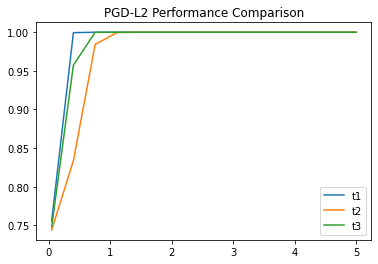

In [27]:
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.legend(['t1', 't2', 't3'])
plt.title('PGD-L2 Performance Comparison')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


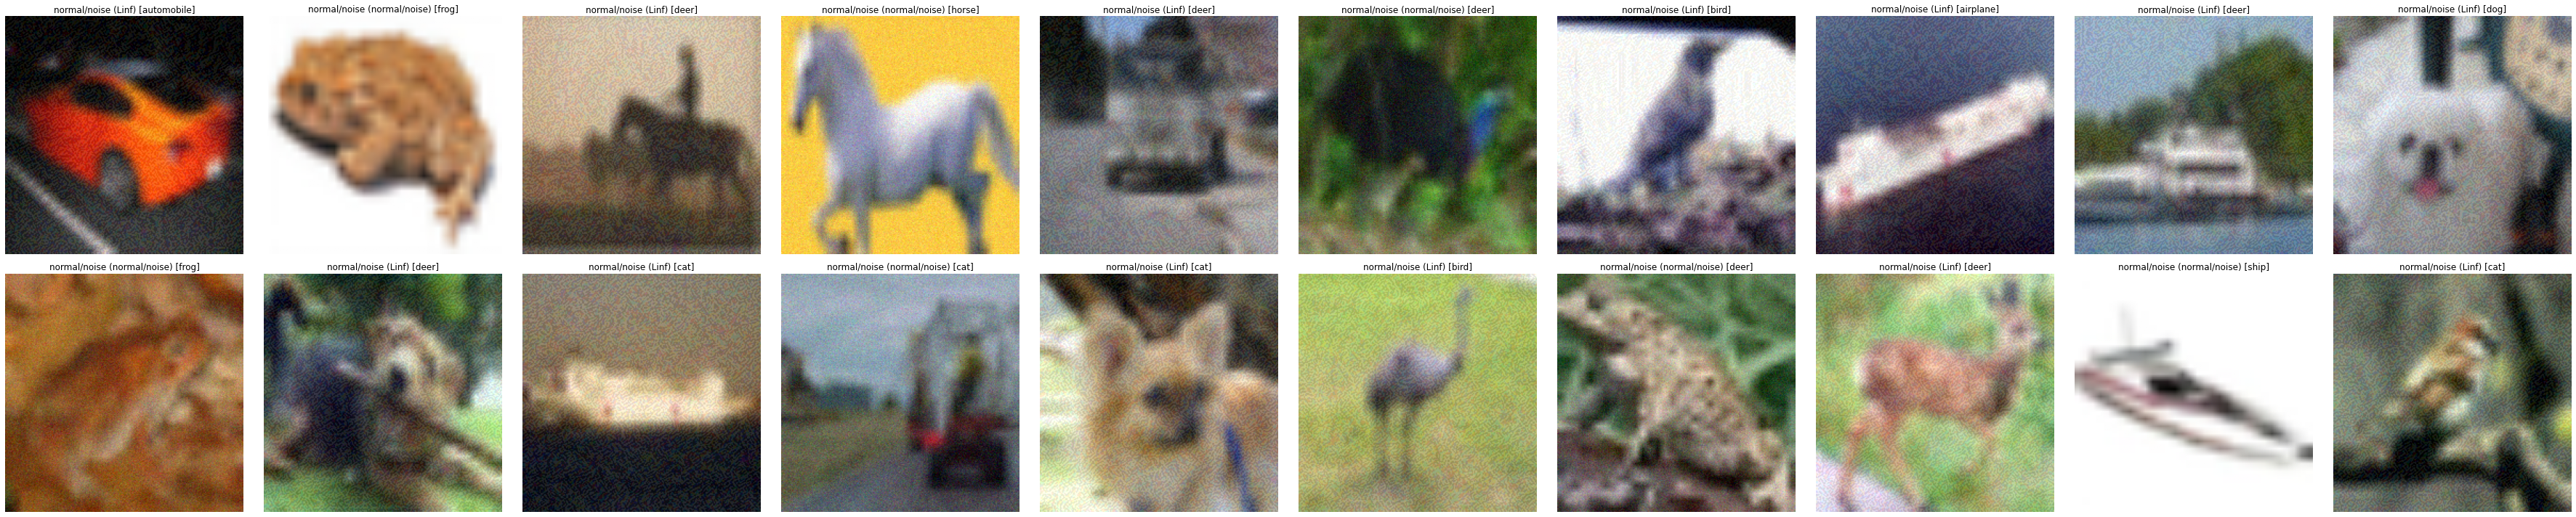

In [23]:
fig=plt.figure(figsize=(50,10))
labels = ['normal/noise', 'Linf', 'L2']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
# labels = ['normal/noise', 'Adversarial']

def inference(model, adv_model, dataset_sample, i):

    sample = dataset_sample[0]
    X = sample.unsqueeze(0)
    X = X.to(device)

    y_hat_adv = adv_model(X) 
    y_prob_adv = F.softmax(y_hat_adv, dim=1)
    _, predicted_labels_adv = torch.max(y_prob_adv, 1)

    y_hat = model(X) 
    y_prob = F.softmax(y_hat, dim=1)
    _, predicted_labels = torch.max(y_prob, 1)

    sub = fig.add_subplot(2, 10, i+1)
    # plt.subplot(2, 5, i+1)
    plt.axis('off')
    sub.set_title(labels[predicted_labels.item()] + ' (' + labels[dataset_sample[1]] + ')' + ' [' + classes[predicted_labels_adv.item()] + ']')
    plt.imshow(sample.detach().cpu().permute(1, 2, 0))
    plt.tight_layout()

indices = random.sample(range(0, len(valid_dataset)), 20)
valid_dataset.attack = 'fgsm'
for i, index in enumerate(indices):
    # fgsm_eps = np.random.uniform(0.01, 0.5)
    # fgsm = FGSM(loss_fn=torch.nn.CrossEntropyLoss(), fgsm_epsilon = fgsm_eps)
    inference(model, adv_model, valid_dataset[index], i)

In [ ]:
pgd_linf = PGD(loss_fn=torch.nn.CrossEntropyLoss(), num_steps = 5, step_size = 0.12, eps = 0.6, step_norm = 'inf', eps_norm = 'inf')
pgd_l2 = PGD(loss_fn=torch.nn.CrossEntropyLoss(), num_steps = 5, step_size = 0.5, eps = 2.5, step_norm = 2, eps_norm = 2)
fgsm = FGSM(loss_fn=torch.nn.CrossEntropyLoss(), fgsm_epsilon = 0.01)
cw = torchattacks.CW(adv_model, c=1, kappa=0, steps=5, lr=0.1)
deepfool = torchattacks.DeepFool(adv_model, steps=50, overshoot=0.2)

In [ ]:
BATCH_SIZE = 16

vgg_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

inf_train_dataset = datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = vgg_transform)

inf_valid_dataset = datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = vgg_transform)

wt_vgg_train_loader = DataLoader(inf_train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True)

wt_vgg_valid_loader = DataLoader(inf_valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True)

fig=plt.figure(figsize=(50,10))

indices = random.sample(range(0, len(inf_valid_dataset)), 10)
inf_valid_dataset.attack = 'fgsm'
for i, index in enumerate(indices):

    sample = []

    # attack = torchattacks.VANILA(adv_model)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), inf_valid_dataset[index][1]).squeeze(0))
    # sample.append(0)

    # attack = torchattacks.GN(adv_model, std=0.1)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), inf_valid_dataset[index][1]).squeeze(0))
    # sample.append(0)

    # attack = torchattacks.BIM(adv_model, eps=40/255, alpha=4/255, steps=10)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.RFGSM(adv_model, eps=16/255, alpha=8/255, steps=5)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.EOTPGD(adv_model, eps=4/255, alpha=8/255, steps=40, eot_iter=10)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.TPGD(adv_model, eps=8/255, alpha=2/255, steps=7)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.FFGSM(adv_model, eps=8/255, alpha=10/255)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.MIFGSM(adv_model, eps=8/255, steps=5, decay=1.0)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.APGD(adv_model, norm='L2', eps=80/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(2)

    attack = torchattacks.FAB(adv_model, norm='L2', steps=10, eps=None, n_restarts=1, alpha_max=0.1, eta=1.05, beta=0.9, verbose=False, seed=0, targeted=False, n_classes=10)
    sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    sample.append(2)

    # attack = torchattacks.Jitter(adv_model, eps=0.3, alpha=2/255, steps=40, scale=10, std=0.1, random_start=True)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)
    
    inference(model, adv_model, sample, i)

In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/t4.pkl', 'wb'))

In [ ]:
# if device == 'cpu':
#     model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/3_class_detection_224_CIFAR10.pkl', 'rb')).load()
# else:
#     model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/3_class_detection_224_CIFAR10.pkl', 'rb')).to(device)